#PAMPA Permeability, NCATS
## End-to-end binary Classification via supervised graph neural networks (GNN) using PyG
Based on the SMILES string of a compound, using **GNN algorithms**, this tutorial explains how to predict whether it will have high permeability (1) or low-to-moderate permeability (0) in the **PAMPA assay** using PyG framework. 

There are different frameworks to model GNN algorithms including PyG, DGL, DeepPurpose, Tf-gnn, etc. In this tutorial, we will use **PyG** as one of the best GNN frameworks in this field. 

**Dataset Description:** PAMPA (parallel artificial membrane permeability assay) is a commonly employed assay to evaluate drug permeability across the cellular membrane. PAMPA is a non-cell-based, low-cost and high-throughput alternative to cellular models. Although PAMPA does not model active and efflux transporters, it still provides permeability values that are useful for absorption prediction because the majority of drugs are absorbed by passive diffusion through the membrane. 

**References:**
[1] Siramshetty, V.B., Shah, P., et al. “Validating ADME QSAR Models Using Marketed Drugs.” SLAS Discovery 2021 Dec;26(10):1326-1336. doi: 10.1177/24725552211017520.

**Dataset License:** Not Specified. CC BY 4.0.

**Dataset Statistics:** NCATS set - 2035 compounds; Approved drugs set - 142 drugs. 

###**This is an end-to-end tutorial that consists of nine steps:**

1.   **Step 1:** Import Packages
2.   **Step 2:** Import dataset
3.   **Step 3:** Split dataset
4.   **Step 4:** Data preprocessing: Converting SMILES string into a molecular graph for Pytorch Geometric
5.   **Step 5:** Data visualisation
6.   **Step 6:** Building a GNN (GCN) model:Training a Graph Neural Network (GNN)
7.   **Step 7:** Create a training and testing loop to fit the model
8.   **Step 8:** Plot the loss&accuracy curves of Model
9.   **Step 9:** Evaluate the model on the whole Test set


**Note:** This file has been designed to run on Colab + GPU


##Step 0: Install libraries

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install networkx[default]
!pip install scipy

# Let's calculuate the accuracy
!pip -q install torchmetrics # colab doesn't come with torchmetrics

# Install rdkit
!pip install rdkit

# Install Chemical libraries (TDC dataset, deepchem, PubChemPy)
!pip install PyTDC
!pip install --pre deepchem
!pip install DeepPurpose
!pip install PubChemPy
!pip install git+https://github.com/samoturk/mol2vec
!pip install 'mordred[full]'

##Step 1: Import Packages

In [148]:
# Import necessary libraries
# Pytorch and Pytorch Geometric
import torch
import torch_geometric
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
#from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader #use for GNN problems
from torch_geometric.transforms import NormalizeFeatures
from torchmetrics import Accuracy # colab doesn't come with torchmetrics
from torch_geometric.nn.conv.rgat_conv import ReLU
from torch_geometric.nn import GCNConv

# Import general libraries
import sys
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx

# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

# Imoprt Chemical libraries and dataset
from tdc.single_pred import ADME
import deepchem
from mol2vec import features
from mol2vec import helpers
import mordred

### 1.1  Setup device-agnostic code

In [149]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Step 2: Import [dataset](https://tdcommons.ai/single_pred_tasks/adme#pampa-permeability-ncats)

In [150]:
# import dataset
from tdc.single_pred import ADME
data = ADME(name = 'PAMPA_NCATS')
split = data.get_split()

Found local copy...
Loading...
Done!


## Step 3: Split dataset

In [151]:
train = split['train']
valid = split['valid']
test = split['test']

#====================================
X_train = train['Drug'].to_numpy()
y_train = train['Y'].to_numpy()

X_valid = valid['Drug'].to_numpy()
y_valid = valid['Y'].to_numpy()

X_test = test['Drug'].to_numpy()
y_test = test['Y'].to_numpy()

#====================================
print(f"X_train: {X_train[0:1]}, X_train shape:{X_train.shape}")
print(f"y_train: {y_train[0:1]}, y_train shape:{y_train.shape}")
print()
print(f"X_valid: {X_valid[0:1]}, X_valid shape:{X_valid.shape}")
print(f"y_valid: {y_valid[0:1]}, y_valid shape:{y_valid.shape}")
print()
print(f"X_test: {X_test[0:1]}, X_test shape:{X_test.shape}")
print(f"y_test: {y_test[0:1]}, y_test shape:{y_test.shape}")

X_train: ['COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC'], X_train shape:(1424,)
y_train: [0], y_train shape:(1424,)

X_valid: ['CC1=C(C=C(C=C1)C2=NC3=CC=CC=C3C(=C2)C(=O)NC4=CC=C(C=C4)S(=O)(=O)NCC5=NC=CS5)C'], X_valid shape:(203,)
y_valid: [0], y_valid shape:(203,)

X_test: ['C[C@]12C[C@H]([C@@H]([C@@]1(CC(=O)[C@@]3([C@H]2CC=C4[C@H]3C=C(C(=O)C4(C)C)O)C)C)[C@](C)(C(=O)/C=C\\C(C)(C)O)O)O'], X_test shape:(407,)
y_test: [1], y_test shape:(407,)


In [152]:
train.head()

,Drug_ID,Drug,Y
0,1259573,COC1=C(C=C(C=C1)CCN2C(=CC(=O)NC2=S)N)OC,0
1,1275864,COC1=C(C=C(C=C1)Cl)C(=O)NC2=CC=C(C=C2)NC(=O)C3...,1
2,2030130,CN1C2=CC=CC=C2C(=O)C3=C1N=C(N(C3=O)C4=CC=CC=C4...,1
3,4422695,CC1=C(C=C(C=C1)NS(=O)(=O)C2=CC=CC(=C2)C(=O)O)S...,1
4,1131802,COC1=CC(=CC(=C1O)OC)C2=NC(=C(N2)C3=CC=CS3)C4=C...,1


## Step 4: [Data preprocessing](https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/): Converting SMILES string into a molecular graph for Pytorch Geometric
* 1. Atom Featurisation
* 2. Bond Featurisation
* 3. Generating labeled Pytorch Geometric Graph Objects
* 4. Data prepration



### 4.1 Atom Featurisation

We start by defining an auxiliary function which transforms a value x into a one-hot encoding based on a list of permitted values for x:

Auxiliary function

In [153]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """

    if x not in permitted_list:
        x = permitted_list[-1]

    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]

    return binary_encoding

Now we use this auxiliary function to define the actual atom featurisation function:

In [154]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

### 4.2 Bond Featurisation
Now that we have constructed a function to conveniently turn RDKit atom objects into feature vectors, we define an analogous function for RDKit bond objects:

In [155]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

The bond features we consider in the above function are: bond type, whether the bond is conjugated, and whether the bond is in a ring. As an additional option, the user can specify whether to include E-Z stereochemical features around double bonds. 

### 4.3 Generating labeled Pytorch Geometric Graph Objects
Equipped with suitable functions to turn RDKit atom objects and RDKit bond objects into informative feature vectors, we swiftly move on to define a function which turns a list of SMILES strings and an associated list of labels (such as pKi values) into a list of Pytorch Geometric graph objects:

In [156]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list + to(device) to make the data device agnostic.
        data_list.append(Data(x = X.to(device), edge_index = E.to(device), edge_attr = EF.to(device), y = y_tensor.to(device)))

    return data_list

### 4.4 Data processing
**Note:** PyTorch Geometric DataLoader `torch_geometric.data.DataLoader` should be use in **GNN** problems  instead of the one provided by PyTorch `torch.utils.data.DataLoader`.


In [157]:
#Data prepration
from torch_geometric.data import DataLoader

#Hyperparameters:
BATCH_SIZE = 64 #@param 


# Train dataset
train_data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(X_train, y_train) # create list of molecular graph objects from list of SMILES x_smiles and list of labels y
train_dataloader = DataLoader(dataset = train_data_list, batch_size = BATCH_SIZE, shuffle=True) # create dataloader for training
  
# Vildation dataset
valid_data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(np.array(X_valid), np.array(y_valid))
valid_dataloader = DataLoader(dataset = valid_data_list, batch_size = BATCH_SIZE, shuffle=False)

# Test dataset
test_data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(np.array(X_test), np.array(y_test))
test_dataloader = DataLoader(dataset = test_data_list, batch_size = BATCH_SIZE, shuffle=False)

Get the first graph object
* ee a sample of transformed data

In [158]:
dataset = train_data_list[0]
print(dataset)
print(dataset.x)
print(dataset.y)

Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1])
tensor([[1., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 0.]], device='cuda:0')
tensor([0.], device='cuda:0')


### 4.5 Dataset properties

In [159]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {2}')

print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {dataset.num_nodes}')
print(f'Number of edges: {dataset.num_edges}')
print(f'Average node degree: {dataset.num_edges / dataset.num_nodes:.2f}')
print(f'Has isolated nodes: {dataset.has_isolated_nodes()}')
print(f'Has self-loops: {dataset.has_self_loops()}')
print(f'Is undirected: {dataset.is_undirected()}')

Dataset: Data(x=[21, 79], edge_index=[2, 44], edge_attr=[44, 10], y=[1]):
Number of graphs: 4
Number of features: 79
Number of classes: 2
Number of nodes: 21
Number of edges: 44
Average node degree: 2.10
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### 4.6 Define dataset features and classes


In [160]:
num_node_features = dataset.num_features
num_classes = 2

## Step 5: Data visualisation

In [161]:
def visualize_graph(G, color):
    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()

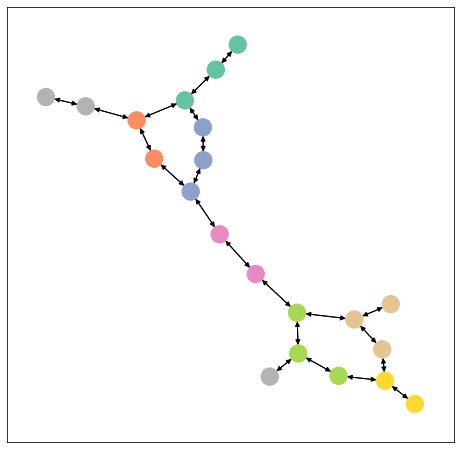

In [162]:
from torch_geometric.utils import to_networkx

undirected_graph = to_networkx(dataset)
visualize_graph(undirected_graph, color=[i for i in range(len(dataset.x))])

## Step 6: Building a GNN (GCN) model:Training a Graph Neural Network (GNN)

In [163]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, SAGEConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super(GCN, self).__init__()
    torch.manual_seed(12345)
    self.conv1 = GraphConv(num_node_features, hidden_channels)
    self.conv2 = GraphConv(hidden_channels, hidden_channels)
    self.conv3 = GraphConv(hidden_channels, hidden_channels)
    self.lin = Linear(hidden_channels, num_classes)

  def forward(self, x, edge_index, batch):
    # 1. Obtain node embeddings 
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = self.conv2(x, edge_index)
    x = x.relu()
    x = self.conv3(x, edge_index)

    # 2. Readout layer
    x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

    # 3. Apply a final classifier
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.lin(x)
        
    return x

## Step 7: Create a training and testing loop to fit the model

### 7.1 Claculate accuracy, F1_ score, ROC-AUC, PR-AUC

In [164]:
from torchmetrics import Accuracy, F1Score, PrecisionRecallCurve, AUROC

#@markdown Hyperparameters
#Hyperparameters
task = "multiclass" #@param ['binary', 'multiclass', 'multilabel']

# Calculuate the accuracy
acc_fn = Accuracy(task=task, num_classes=num_classes).to(device) # send accuracy function to device
# Calculuate the F1Score
f1_score = F1Score(task=task, num_classes=num_classes).to(device)
# Calculuate the ROC-AUC
roc_auc = AUROC(task="binary", num_classes=num_classes)
# Calculuate the PR-AUC
pr_auc = PrecisionRecallCurve(task="binary", num_classes=num_classes)

### 7.2 Defining train_step function

In [165]:
# define a function for the train step
def train_step(model: torch.nn.Module,
               train_dataloader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn):
  ## Training
  model.train()

  for data in train_dataloader:  # Iterate in batches over the training dataset.
    # Send data to target device
    
    x = data.x.to(device)
    y = data.y.type(torch.LongTensor).to(device) # we should converting the type of "targets=data.y" to "torch.LongTensor" before storing the data into the GPU
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)

    # 1. Forward pass
    out = model(x, edge_index, batch)  # Perform a single forward pass.
    y_pred = torch.softmax(out, dim=1).argmax(dim=1)
    
    # 2. Calculate loss (per batch)
    loss = loss_fn(out, y)  # Compute the loss.
    acc = acc_fn(y_pred, y) # Compute the accuracy 
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()  # Clear gradients.
    
    # 4. Loss backward
    loss.backward()  # Derive gradients.
    
    # 5. Optimizer step
    optimizer.step()  # Update parameters based on gradients.
  
  # We can return "loss" and "acc" rather than "loss.cpu().detach().numpy()" and "acc.cpu().detach().numpy()".
  # But in order to create a loss/acc plot of our model we should convert them to the format of "numpy" and "device=CPU" using ".cpu().detach().numpy()" code.
  return loss.cpu().detach().numpy(), acc.cpu().detach().numpy() 

### 7.3 Defining validation_step function

In [166]:
def validation_step(model: torch.nn.Module,
                    test_dataloader,
                    loss_fn: torch.nn.Module,
                    acc_fn):
  
  ### Validation
  model.eval()

  for data in test_dataloader:
    # Send data to target device
    x = data.x.to(device)
    y = data.y.type(torch.LongTensor).to(device) # we should converting the type of "targets=data.y" to "torch.LongTensor" before storing the data into the GPU
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)

    with torch.inference_mode():
      # 1. Forward pass
      out = model(x, edge_index, batch)
      val_pred = torch.softmax(out, dim=1).argmax(dim=1)

      # 2. Caculate loss and acc
      val_loss = loss_fn(out, y)
      val_acc = acc_fn(val_pred, y)
    #print(f"Validation loss: {val_loss:.5f} | Validation accuracy: {val_acc:.2f}%")

  # We can return "loss" and "acc" rather than "loss.cpu().detach().numpy()" and "acc.cpu().detach().numpy()".
  # But in order to create a loss/acc plot of our model we should convert them to the format of "numpy" and "device=CPU" using ".cpu().detach().numpy()" code.
  return val_loss.cpu().detach().numpy(), val_acc.cpu().detach().numpy()

### 7.4 Define Train function including train steps and test steps 

In [167]:
# Create a timer function to calculate time of training
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [168]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader, 
          test_dataloader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          acc_fn,
          epochs: int = 5):
  
  # 2. Create empty results dictionary
  results = {"train_loss": [],
        "train_accuracy": [],
        "validation_loss": [],
        "validation_accuracy": []
  }
    
  for epoch in tqdm(range(epochs)):
    loss, acc = train_step(model=model,
                          train_dataloader=train_dataloader,
                          loss_fn=loss_fn,
                          optimizer=optimizer,
                          acc_fn=acc_fn)
    
    val_loss, val_acc = validation_step(model=model,
                                        test_dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        acc_fn=acc_fn)
        
    #4. Print out what's happening
    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {loss:.4f} | "
          f"train_accuracy: {acc*100:.2f}% | "
          f"validation_loss: {val_loss:.4f} | "
          f"validation_accuracy: {val_acc*100:.2f}%"
    )

    # 5. Update results dictionary
    results["train_loss"].append(loss)
    results["train_accuracy"].append(acc)
    results["validation_loss"].append(val_loss)
    results["validation_accuracy"].append(val_acc)

  #6. Return the filled results at the end of the epochs
  return results

### 7.5 Train and Evaluate Model

In [169]:
#@markdown Hyperparameters

# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Hyperparameters
NUM_EPOCHS = 75 #@param
learning_rate = 0.001 #@param
weight_decay = 5e-4 #@param
HIDDEN_CHANNELS_GCN = 128 #@param

# GNN (GCN) model: Recreate an instance of the mlp model: input channel is equal to "dataset.num_features", and the output_channel is equal to "dataset.num_classes."
model_GCN = GCN(hidden_channels=HIDDEN_CHANNELS_GCN).to(device)
    
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_GCN.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_GCN_results = train(model=model_GCN, 
                          train_dataloader=train_dataloader, 
                          test_dataloader=test_dataloader,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          acc_fn=acc_fn,
                          epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/75 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4504 | train_accuracy: 87.50% | validation_loss: 0.4559 | validation_accuracy: 82.61%
Epoch: 2 | train_loss: 0.3993 | train_accuracy: 87.50% | validation_loss: 0.4515 | validation_accuracy: 82.61%
Epoch: 3 | train_loss: 0.2935 | train_accuracy: 93.75% | validation_loss: 0.4445 | validation_accuracy: 82.61%
Epoch: 4 | train_loss: 0.2528 | train_accuracy: 93.75% | validation_loss: 0.4476 | validation_accuracy: 82.61%
Epoch: 5 | train_loss: 0.1425 | train_accuracy: 100.00% | validation_loss: 0.4429 | validation_accuracy: 82.61%
Epoch: 6 | train_loss: 0.2797 | train_accuracy: 93.75% | validation_loss: 0.4326 | validation_accuracy: 82.61%
Epoch: 7 | train_loss: 0.4620 | train_accuracy: 81.25% | validation_loss: 0.4487 | validation_accuracy: 82.61%
Epoch: 8 | train_loss: 0.3657 | train_accuracy: 87.50% | validation_loss: 0.4308 | validation_accuracy: 82.61%
Epoch: 9 | train_loss: 0.3739 | train_accuracy: 87.50% | validation_loss: 0.4325 | validation_accuracy: 82.61%


## Step 8: Plot the loss&accuracy curves of Model 

Create plot_loss_curves function

In [170]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['validation_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_accuracy']
    test_accuracy = results['validation_accuracy']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='validation_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Plot loss curves model GCN

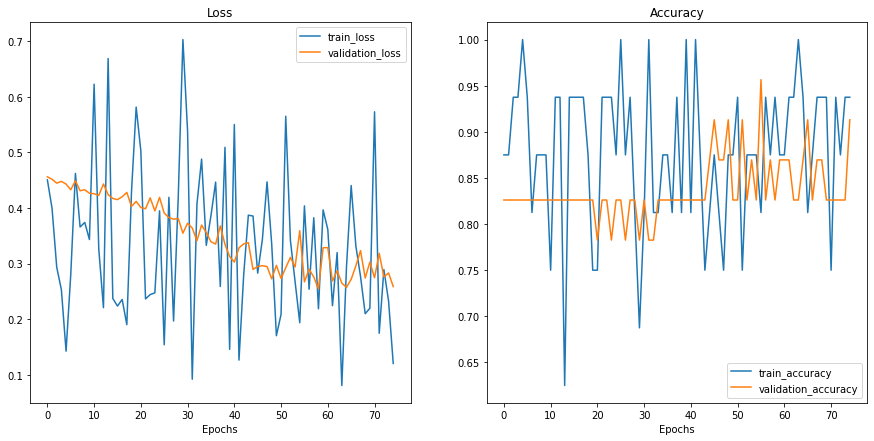

In [171]:
#Plot loss/acc model_GCN
plot_loss_curves(model_GCN_results)

## Step 9: Evaluate the model on the whole Test set

### 9.1 Evaluation function

In [172]:
def evaluation(model: torch.nn.Module,
               test_dataloader,
               loss_fn: torch.nn.Module,
               acc_fn):
  
  ### Test evaluation
  model.eval()

  for data in test_dataloader:
    # Send data to target device
    x = data.x.to(device)
    y = data.y.type(torch.LongTensor).to(device)
    edge_index = data.edge_index.to(device)
    batch = data.batch.to(device)

    with torch.inference_mode():
      # 1. Forward pass
      out = model(x, edge_index, batch)
      test_pred = torch.softmax(out, dim=1).argmax(dim=1)

      # 2. Caculate loss and acc
      test_loss = loss_fn(out, y)
      test_acc = acc_fn(test_pred, y)
      
      # 3. Caculate f1_score
      test_f1_score = f1_score(test_pred, y)
      
      # 4. Caculate roc_auc
      test_roc_auc = roc_auc(test_pred.type(torch.float32), y)
      test_roc_auc =test_roc_auc.cpu().detach().numpy().tolist()

      # 5. Caculate pr_auc
      test_pr_auc = pr_auc(test_pred.type(torch.float32), y)
      test_pr_auc = (test_pr_auc[0][0]).cpu().detach().numpy().tolist()

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": test_loss.item(),
          "model_accuracy": test_acc.item(),
          "model_f1_score": test_f1_score.item(),
          "model_roc_auc_score": test_roc_auc,
          "model_pr_auc_score": test_pr_auc}

### 9.2 GCN model evaluation



In [173]:
# Evaluate model on the test set
model_evaluation_GCN = evaluation(model=model_GCN,
                                  test_dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  acc_fn=acc_fn)

model_evaluation_GCN

{'model_name': 'GCN',
 'model_loss': 0.25857317447662354,
 'model_accuracy': 0.9130434989929199,
 'model_f1_score': 0.9130434989929199,
 'model_roc_auc_score': 0.75,
 'model_pr_auc_score': 0.9047619104385376}